<a href="https://colab.research.google.com/github/CharlesPoletowin/YCBS-273/blob/master/Lecture2_mlp_tricks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

Disclaimer: This notebook is modified from the following notebooks:
- https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/nn_tutorial.ipynb#scrollTo=N29T2vcqOnVU

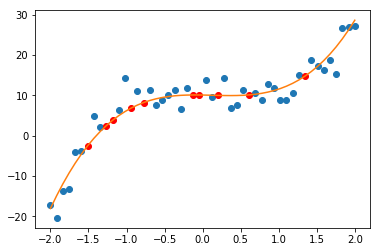

In [0]:
from matplotlib import pyplot as plt
import random
import math
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# fix seeds
SEED = 225
random.seed(SEED)
np.random.seed(SEED)

# data processing
def f(x):
  return (x - 0.2)*(x + 0.3)*(3*x - 1.5) + 10

SIZE = 50
x = np.linspace(-2, 2, SIZE, np.float32)
y = f(x)

n_idx = random.sample(range(50), 15)

y_noise = y + 3 * np.random.randn(SIZE)

idx = list(range(SIZE))
np.random.shuffle(idx)

x_train, y_train, x_test, y_test = x[idx][:40], y_noise[idx][:40], x[idx][40:], y[idx][40:]

x_train, y_train, x_test, y_test = map(
    torch.FloatTensor, (x_train[:, np.newaxis], y_train[:, np.newaxis], x_test[:, np.newaxis], y_test[:, np.newaxis])
)
n, _ = x_train.shape

plt.plot(x_train.numpy(), y_train.detach().numpy(), 'o')
plt.plot(x_test.numpy(), y_test.detach().numpy(), 'ro')
plt.plot(x, y, '-')

In [0]:
x_train

tensor([[ 1.9184],
        [ 1.4286],
        [-0.6122],
        [-1.3469],
        [ 1.7551],
        [-1.1020],
        [-0.3673],
        [ 1.5102],
        [ 1.6735],
        [-0.2041],
        [ 0.9388],
        [ 1.1837],
        [-0.6939],
        [-1.7551],
        [-1.6735],
        [ 0.8571],
        [-1.4286],
        [ 2.0000],
        [-0.8571],
        [ 0.2857],
        [-1.8367],
        [ 1.5918],
        [ 0.6939],
        [ 0.4490],
        [ 0.5306],
        [ 1.8367],
        [ 1.1020],
        [-1.5918],
        [ 0.3673],
        [-0.2857],
        [ 0.1224],
        [ 0.7755],
        [-0.4490],
        [ 0.0408],
        [-0.5306],
        [ 1.0204],
        [ 1.2653],
        [-1.0204],
        [-2.0000],
        [-1.9184]])

In [0]:
def train_model(model, x_train, y_train, x_test, y_test, epochs=250, batch_size=10, lr=0.01, weight_decay=0):
  # data
  train_dataset = TensorDataset(x_train, y_train)
  train_data_loader = DataLoader(train_dataset, batch_size=batch_size)

  # loss function
  loss_func = F.mse_loss

  # optimizer
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

  # training loop
  y_pred = model(x_test)
  print('Test error of model before training: ', loss_func(y_pred, y_test))

  train_loss = []
  test_loss = []
  for epoch in range(epochs):
    epoch_loss = 0
    
    for xb, yb in train_data_loader:
      
      pred = model(xb)
      loss = loss_func(pred, yb)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      
      epoch_loss += loss
    
    y_pred = model(x_test)
    test_loss.append(loss_func(y_pred, y_test))
    train_loss.append(epoch_loss/len(train_data_loader))
    
    print('Loss at epoch %d : %f' % (epoch, epoch_loss/len(train_data_loader)))

  # model evaluation
  y_pred = model(x_test)
  print('Test error of model after training: ', loss_func(y_pred, y_test))
  return train_loss, test_loss

In [0]:
def visualize_model(trained_model):
  x = torch.linspace(-2, 2, 50).unsqueeze(1)
  y_ = trained_model.forward(x)
  y = f(x)
  plt.figure()
  plt.plot(x_train.numpy(), y_train.detach().numpy(), 'o')
  plt.plot(x_test.numpy(), y_test.detach().numpy(), 'ro')
  plt.plot(x.numpy(), y_.detach().numpy(), 'b-')
  plt.plot(x.numpy(), y.detach().numpy(), 'k-')

In [0]:
def get_learning_curves(train_loss, test_loss):
  plt.figure()
  plt.plot(train_loss[30:])
  plt.plot(test_loss[30:])
  plt.legend(['Training loss', 'Validation loss'])

### The following seemingly correct model doesn't train.

In [0]:
# model definition
class mlp_regressor(nn.Module):
  def __init__(self):
      super().__init__()
      self.weights_1 = nn.Parameter(torch.randn(1, 512))
      self.bias_1 = nn.Parameter(torch.zeros(512))
      
      self.weights_2 = nn.Parameter(torch.randn(512, 512))
      self.bias_2 = nn.Parameter(torch.zeros(512))
      
      self.weights_3 = nn.Parameter(torch.randn(512, 1))
      self.bias_3 = nn.Parameter(torch.zeros(1))

  def forward(self, xb):
    h =  xb.matmul(self.weights_1) + self.bias_1
    h = F.relu(h)
    h =  h.matmul(self.weights_2) + self.bias_2
    h = F.relu(h)
    h =  h.matmul(self.weights_3) + self.bias_3
    out = h
    return out
  
model = mlp_regressor()
_, _ = train_model(model, x_train, y_train, x_test, y_test, lr=0.000001)

Test error of model before training:  tensor(103720.0547, grad_fn=<MseLossBackward>)
Loss at epoch 0 : 88184.437500
Loss at epoch 1 : 2035.091553
Loss at epoch 2 : 530.837402
Loss at epoch 3 : 441.387756
Loss at epoch 4 : 401.555542
Loss at epoch 5 : 366.754852
Loss at epoch 6 : 334.945923
Loss at epoch 7 : 306.043915
Loss at epoch 8 : 279.824280
Loss at epoch 9 : 255.878998
Loss at epoch 10 : 234.181259
Loss at epoch 11 : 214.384979
Loss at epoch 12 : 196.407043
Loss at epoch 13 : 180.052704
Loss at epoch 14 : 165.137253
Loss at epoch 15 : 151.646240
Loss at epoch 16 : 139.386108
Loss at epoch 17 : 128.256699
Loss at epoch 18 : 118.166603
Loss at epoch 19 : 109.041069
Loss at epoch 20 : 100.804291
Loss at epoch 21 : 93.380280
Loss at epoch 22 : 86.673126
Loss at epoch 23 : 80.597473
Loss at epoch 24 : 75.070679
Loss at epoch 25 : 70.101349
Loss at epoch 26 : 65.618332
Loss at epoch 27 : 61.577393
Loss at epoch 28 : 57.966072
Loss at epoch 29 : 54.690826
Loss at epoch 30 : 51.729134
Lo

# Tricks to tame a diverging model

## Adjusting the learning rate
When the loss blows up, as it is in above case, first thing to try is to decrease the learning rate. The model seems to overfit heavily to the noise. But atleast it's learning!

Test error of model before training:  tensor(26859.6543, grad_fn=<MseLossBackward>)
Loss at epoch 0 : 1267152.750000
Loss at epoch 1 : 222115.906250
Loss at epoch 2 : 1251.366943
Loss at epoch 3 : 890.796021
Loss at epoch 4 : 648.431824
Loss at epoch 5 : 480.726074
Loss at epoch 6 : 360.864258
Loss at epoch 7 : 273.213867
Loss at epoch 8 : 208.713684
Loss at epoch 9 : 161.165253
Loss at epoch 10 : 125.405960
Loss at epoch 11 : 98.636604
Loss at epoch 12 : 78.730026
Loss at epoch 13 : 63.903992
Loss at epoch 14 : 52.768459
Loss at epoch 15 : 44.227325
Loss at epoch 16 : 37.757172
Loss at epoch 17 : 32.775124
Loss at epoch 18 : 28.855206
Loss at epoch 19 : 25.778761
Loss at epoch 20 : 23.304943
Loss at epoch 21 : 21.254219
Loss at epoch 22 : 19.527365
Loss at epoch 23 : 18.152166
Loss at epoch 24 : 17.005974
Loss at epoch 25 : 16.018202
Loss at epoch 26 : 15.161011
Loss at epoch 27 : 14.424515
Loss at epoch 28 : 13.769180
Loss at epoch 29 : 13.183675
Loss at epoch 30 : 12.652834
Loss at 

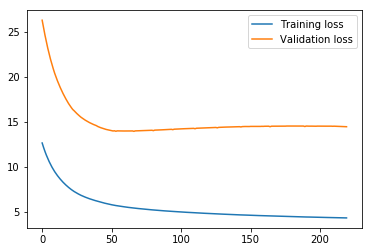

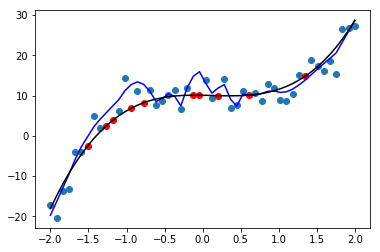

In [0]:
model = mlp_regressor()
train_loss, test_loss = train_model(model, x_train, y_train, x_test, y_test, lr=0.00001)
get_learning_curves(train_loss, test_loss)
visualize_model(model)

## Initialiazation of model parameters

Another approach is to do better initialization of model parameters. Though this isn't particularly useful in this particular example, this showcases the advantage better initialization brings. Also, the overrfitting is relatively less apparent.

Test error of model before training:  tensor(77.4261, grad_fn=<MseLossBackward>)
Loss at epoch 0 : 114.131058
Loss at epoch 1 : 67.354576
Loss at epoch 2 : 67.599602
Loss at epoch 3 : 67.323547
Loss at epoch 4 : 67.020401
Loss at epoch 5 : 66.728973
Loss at epoch 6 : 66.446281
Loss at epoch 7 : 66.169205
Loss at epoch 8 : 65.915146
Loss at epoch 9 : 65.666107
Loss at epoch 10 : 65.461823
Loss at epoch 11 : 65.233551
Loss at epoch 12 : 65.014221
Loss at epoch 13 : 64.815605
Loss at epoch 14 : 64.571915
Loss at epoch 15 : 64.353119
Loss at epoch 16 : 64.139137
Loss at epoch 17 : 63.935829
Loss at epoch 18 : 63.732162
Loss at epoch 19 : 63.544262
Loss at epoch 20 : 63.363228
Loss at epoch 21 : 63.201096
Loss at epoch 22 : 63.021645
Loss at epoch 23 : 62.831833
Loss at epoch 24 : 62.667473
Loss at epoch 25 : 62.490677
Loss at epoch 26 : 62.328453
Loss at epoch 27 : 62.167740
Loss at epoch 28 : 62.028610
Loss at epoch 29 : 61.835674
Loss at epoch 30 : 61.710335
Loss at epoch 31 : 61.531380


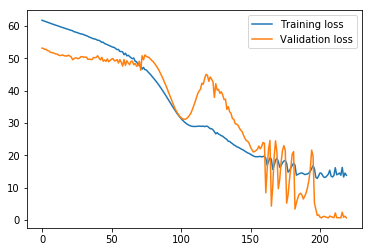

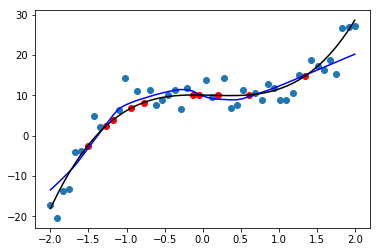

In [0]:
# model definition
class mlp_regressor_glorot(nn.Module):
  def __init__(self):
      super().__init__()
      self.weights_1 = nn.Parameter(torch.randn(1, 800) / math.sqrt(1))
      self.bias_1 = nn.Parameter(torch.zeros(800))
      
      self.weights_2 = nn.Parameter(torch.randn(800, 800) / math.sqrt(800))
      self.bias_2 = nn.Parameter(torch.zeros(800))
      
      self.weights_3 = nn.Parameter(torch.randn(800, 1) / math.sqrt(800))
      self.bias_3 = nn.Parameter(torch.zeros(1))

  def forward(self, xb):
    h =  xb.matmul(self.weights_1) + self.bias_1
    h = F.relu(h)
    h =  h.matmul(self.weights_2) + self.bias_2
    h = F.relu(h)
    h =  h.matmul(self.weights_3) + self.bias_3
    out = h
    return out
  
model = mlp_regressor_glorot()
train_loss, test_loss = train_model(model, x_train, y_train, x_test, y_test, lr=0.001)
get_learning_curves(train_loss, test_loss)
visualize_model(model)

## Changing the activation function

Activation function plays a vital role in the model dynamics. Changing the activation from ReLU to tanh lets the model learn in this case. But it heavily overfits!

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Test error of model before training:  tensor(392.1522, grad_fn=<MseLossBackward>)
Loss at epoch 0 : 1146.182861
Loss at epoch 1 : 287.583221
Loss at epoch 2 : 50.139587
Loss at epoch 3 : 129.631577
Loss at epoch 4 : 271.922760
Loss at epoch 5 : 368.799774
Loss at epoch 6 : 164.741821
Loss at epoch 7 : 52.909515
Loss at epoch 8 : 26.618820
Loss at epoch 9 : 18.946011
Loss at epoch 10 : 12.893161
Loss at epoch 11 : 11.045445
Loss at epoch 12 : 8.712889
Loss at epoch 13 : 7.585568
Loss at epoch 14 : 7.202687
Loss at epoch 15 : 7.547820
Loss at epoch 16 : 9.353034
Loss at epoch 17 : 12.200078
Loss at epoch 18 : 5.489644
Loss at epoch 19 : 7.386570
Loss at epoch 20 : 10.164907
Loss at epoch 21 : 10.111244
Loss at epoch 22 : 12.096265
Loss at epoch 23 : 15.976927
Loss at epoch 24 : 10.448235
Loss at epoch 25 : 15.611908
Loss at epoch 26 : 30.938450
Loss at epoch 27 : 18.595404
Loss at epoch 28 : 18.063162
Loss at epoch 29 : 15.012030
Loss at epoch 30 : 14.595496
Loss at epoch 31 : 16.181208


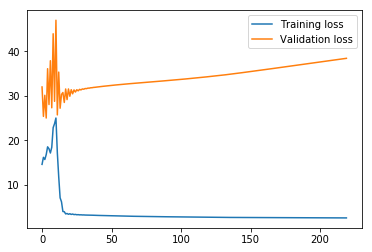

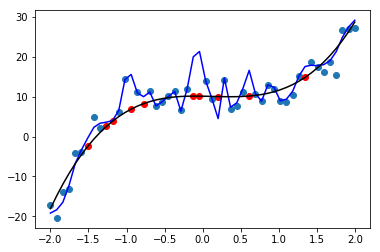

In [0]:
# model definition
class mlp_regressor_tanh(nn.Module):
  def __init__(self):
      super().__init__()
      self.weights_1 = nn.Parameter(torch.randn(1, 512))
      self.bias_1 = nn.Parameter(torch.zeros(512))
      
      self.weights_2 = nn.Parameter(torch.randn(512, 512))
      self.bias_2 = nn.Parameter(torch.zeros(512))
      
      self.weights_3 = nn.Parameter(torch.randn(512, 1))
      self.bias_3 = nn.Parameter(torch.zeros(1))

  def forward(self, xb):
    h =  xb.matmul(self.weights_1) + self.bias_1
    h = F.tanh(h)
    h =  h.matmul(self.weights_2) + self.bias_2
    h = F.tanh(h)
    h =  h.matmul(self.weights_3) + self.bias_3
    out = h
    return out
  
model = mlp_regressor_tanh()
train_loss, test_loss = train_model(model, x_train, y_train, x_test, y_test, lr=0.001)
get_learning_curves(train_loss, test_loss)
visualize_model(model)

Better initialization and more suitable activation function makes our model even better

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Test error of model before training:  tensor(76.2170, grad_fn=<MseLossBackward>)
Loss at epoch 0 : 145.873505
Loss at epoch 1 : 122.819366
Loss at epoch 2 : 118.233887
Loss at epoch 3 : 113.617493
Loss at epoch 4 : 108.771233
Loss at epoch 5 : 103.612602
Loss at epoch 6 : 98.073151
Loss at epoch 7 : 92.105286
Loss at epoch 8 : 85.688217
Loss at epoch 9 : 78.837128
Loss at epoch 10 : 71.615059
Loss at epoch 11 : 64.145180
Loss at epoch 12 : 56.618172
Loss at epoch 13 : 49.285133
Loss at epoch 14 : 42.425529
Loss at epoch 15 : 36.292747
Loss at epoch 16 : 31.061810
Loss at epoch 17 : 26.810162
Loss at epoch 18 : 23.543560
Loss at epoch 19 : 21.253475
Loss at epoch 20 : 19.967718
Loss at epoch 21 : 19.719509
Loss at epoch 22 : 20.350262
Loss at epoch 23 : 21.285851
Loss at epoch 24 : 21.799973
Loss at epoch 25 : 21.675432
Loss at epoch 26 : 21.226812
Loss at epoch 27 : 20.773792
Loss at epoch 28 : 20.427586
Loss at epoch 29 : 20.177956
Loss at epoch 30 : 19.987141
Loss at epoch 31 : 19.82

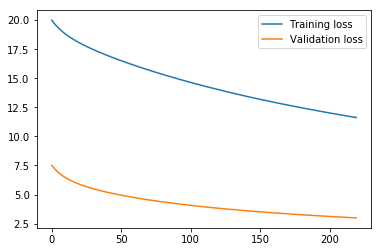

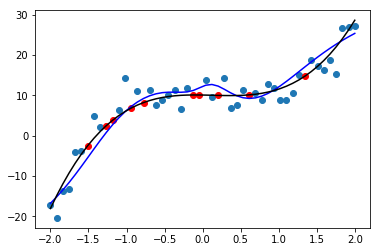

In [0]:
# model definition
class mlp_regressor_tanh_glorot(nn.Module):
  def __init__(self):
      super().__init__()
      self.weights_1 = nn.Parameter(torch.randn(1, 512) / math.sqrt(1))
      self.bias_1 = nn.Parameter(torch.zeros(512))
      
      self.weights_2 = nn.Parameter(torch.randn(512, 512) / math.sqrt(512))
      self.bias_2 = nn.Parameter(torch.zeros(512))
      
      self.weights_3 = nn.Parameter(torch.randn(512, 1) / math.sqrt(512))
      self.bias_3 = nn.Parameter(torch.zeros(1))

  def forward(self, xb):
    h =  xb.matmul(self.weights_1) + self.bias_1
    h = F.tanh(h)
    h =  h.matmul(self.weights_2) + self.bias_2
    h = F.tanh(h)
    h =  h.matmul(self.weights_3) + self.bias_3
    out = h
    return out
  
model = mlp_regressor_tanh_glorot()
train_loss, test_loss = train_model(model, x_train, y_train, x_test, y_test, lr=0.001)
get_learning_curves(train_loss, test_loss)
visualize_model(model)

## L2 regularization

The model with better activation and initialization works fine, but it still seems to overfit to some extent. This can be attributed to the noise in the data and it may not always be possible to completely recover the underlying function. But anothere trick under our hats is to regularize the model weights from getting too large. This limits the complexity of the model.

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Test error of model before training:  tensor(76.1674, grad_fn=<MseLossBackward>)
Loss at epoch 0 : 144.984787
Loss at epoch 1 : 121.495514
Loss at epoch 2 : 116.919937
Loss at epoch 3 : 112.306503
Loss at epoch 4 : 107.454475
Loss at epoch 5 : 102.283539
Loss at epoch 6 : 96.724854
Loss at epoch 7 : 90.730347
Loss at epoch 8 : 84.279831
Loss at epoch 9 : 77.389809
Loss at epoch 10 : 70.125969
Loss at epoch 11 : 62.617504
Loss at epoch 12 : 55.066216
Loss at epoch 13 : 47.737873
Loss at epoch 14 : 40.925079
Loss at epoch 15 : 34.887390
Loss at epoch 16 : 29.798363
Loss at epoch 17 : 25.731730
Loss at epoch 18 : 22.694130
Loss at epoch 19 : 20.681076
Loss at epoch 20 : 19.705559
Loss at epoch 21 : 19.723703
Loss at epoch 22 : 20.437038
Loss at epoch 23 : 21.221821
Loss at epoch 24 : 21.526632
Loss at epoch 25 : 21.314344
Loss at epoch 26 : 20.882191
Loss at epoch 27 : 20.465073
Loss at epoch 28 : 20.136894
Loss at epoch 29 : 19.887585
Loss at epoch 30 : 19.688910
Loss at epoch 31 : 19.51

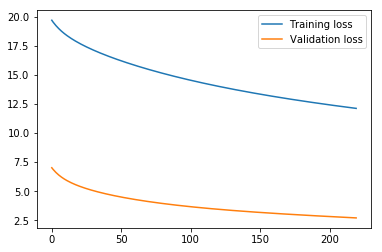

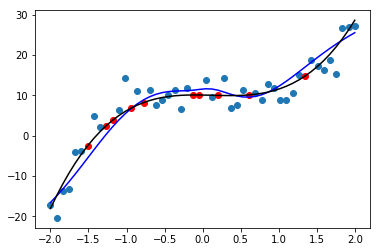

In [0]:
model = mlp_regressor_tanh_glorot()
train_loss, test_loss = train_model(model, x_train, y_train, x_test, y_test, lr=0.001, weight_decay=0.135)
get_learning_curves(train_loss, test_loss)
visualize_model(model)